### Prueba 1 - Hito 2 - Javier Rojas Benitez - G56

In [26]:
import importlib

import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from funciones_auxiliares_hito_2 import codificar_sentimientos

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 10)


In [27]:
df = pd.read_csv("input/training_tweets.csv").drop(columns="Unnamed: 0")

# Preprocesamiento

## Variables independientes

In [28]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

STOPWORDS_INGLES = set(stopwords.words("english"))


In [29]:
def preprocesar_texto_lema(texto):
    tokens = texto.split()
    filtro_stop_words = [palabra for palabra in tokens if palabra not in STOPWORDS_INGLES]
    lematizacion = [lemmatizer.lemmatize(palabra, "v") for palabra in filtro_stop_words]

    texto_juntado = " ".join(lematizacion)

    return texto_juntado


def preprocesar_texto_stem(texto):
    tokens = texto.split()
    filtro_stop_words = [palabra for palabra in tokens if palabra not in STOPWORDS_INGLES]
    stemmizacion = [stemmer.stem(palabra, "v") for palabra in filtro_stop_words]

    texto_juntado = " ".join(stemmizacion)

    return texto_juntado

In [30]:
df["procesados_lema"] = df.content.str.lower().apply(preprocesar_texto_lema)
df["procesados_stem"] = df.content.str.lower().apply(preprocesar_texto_stem)

In [6]:
def obtener_100_palabras_mas_frecuentes(serie_textos):
    """Funcion que permite obtener las 100 palabras mas frecuentes de una lista de
    textos

    :param serie_palabras: Array de textos a analizar
    :type serie_palabras: pd.Series

    :returns: Las 100 palabras mas frecuentes para el array de textos
    :rtype: pd.DataFrame
    """
    count_vectorizer = CountVectorizer(stop_words="english")
    count_vectorizer_fit = count_vectorizer.fit_transform(serie_textos)
    words = count_vectorizer.get_feature_names_out()
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)

    conteo_palabras = pd.DataFrame(words_freq, index=words, columns=["conteo"])
    conteo_palabras = conteo_palabras.sort_values("conteo", ascending=False)
    conteo_palabras = conteo_palabras.reset_index(names="palabra")

    return conteo_palabras


In [7]:
df_lema = obtener_100_palabras_mas_frecuentes(df["procesados_lema"])
df_stem = obtener_100_palabras_mas_frecuentes(df["procesados_stem"])


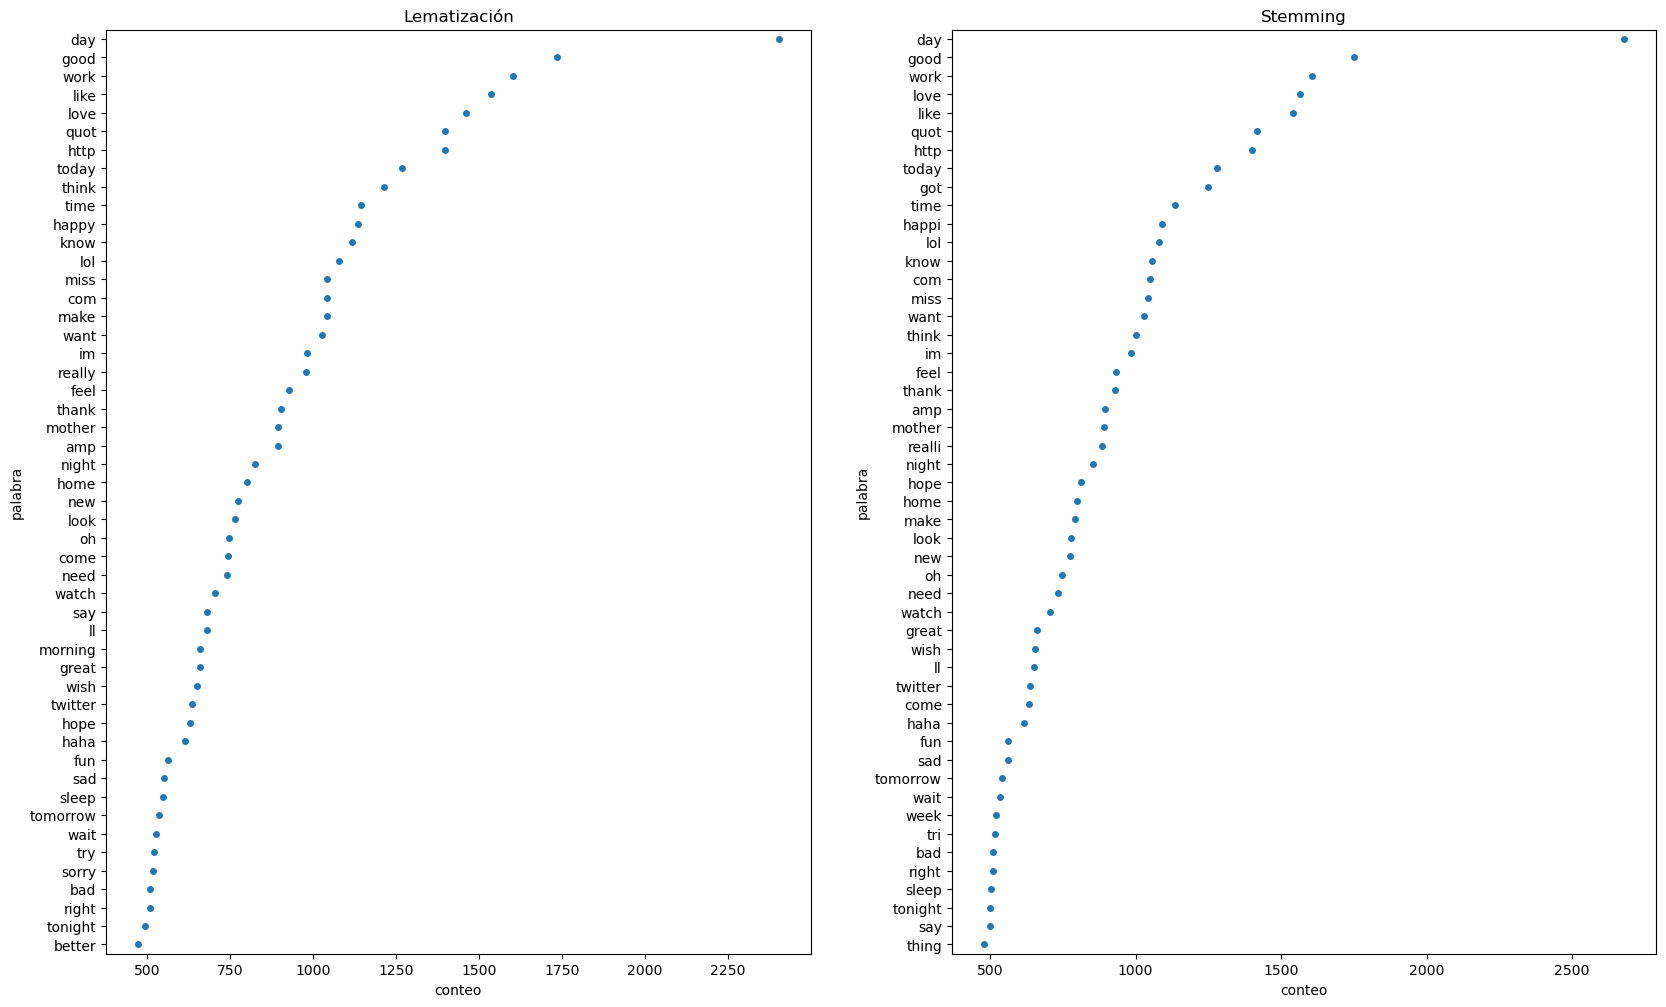

La cantidad de palabras distintas en la lematizacion fue: 37681
La cantidad de palabras distintas en el stemming fue: 37497


In [31]:
figure, axis = plt.subplots(1, 2, figsize=(20, 12))

sns.stripplot(data=df_lema.head(50), x="conteo", y="palabra", ax=axis[0])
sns.stripplot(data=df_stem.head(50), x="conteo", y="palabra", ax=axis[1])
axis[0].set_title("Lematización")
axis[1].set_title("Stemming")
plt.show()


print(f"La cantidad de palabras distintas en la lematizacion fue: {df_lema.shape[0]}")
print(f"La cantidad de palabras distintas en el stemming fue: {df_stem.shape[0]}")


- La lematización y el stemming presentaron un patrón de palabras bastante similares entre sí.

- La lematización presentó 37681 palabras distintas, mientras el stemming presentó 37497 palabras
distintas. Si nos basamos en este parámetro, el stemming es la mejor táctica para preprocesar el texto
y utilizarlo en un modelo de Machine Learning. Esto, ya que el modelo será más parsimonioso.

- La representación de las palabras con la lematización es más fiel al lenguaje que el stemming.
Ejemplos de este fenómeno ocurre con las siguientes palabras:

|Lematización|Stemming|
|-----------|--------|
happy|happi|
really|realli|

Teniendo en cuenta todos los resultados previos, **se utilizará la técnica de lematización para la
confección de cada modelo**. Esto, porque tiene una mejor interpretación de los datos, a pesar de
ser más costoso computacionalmente.

# Filtracion de palabras poco frecuentes

- Como se menciono en el enunciado, se filtraran todas las palabras que tengan una frecuencia menor
al 0.04% de la cantidad de textos en el dataset.

In [76]:
largo_df = df.shape[0]
filtro_frecuencias = int(round(largo_df * 0.0004, 0))

In [83]:
palabras_a_filtrar = df_lema.query('conteo < @filtro_frecuencias')
cambio_en_palabras = df_lema.shape[0] - palabras_a_filtrar.shape[0]

print(f'Las palabras a filtrar son:\n{palabras_a_filtrar}\n')
print(f'Se pasara de {df_lema.shape[0]} a {cambio_en_palabras} palabras')

Las palabras a filtrar son:
            palabra  conteo
2006             ½ï      11
2007             dh      11
2008             pa      11
2009           melt      11
2010         centre      11
...             ...     ...
37676    hysterical       1
37677     hypocrite       1
37678  hypnoticzexy       1
37679      hypnosis       1
37680     lilmickee       1

[35675 rows x 2 columns]

Se pasara de 37681 a 2006 palabras


- Por lo tanto, se puede ver una disminucion considerable en la cantidad de palabras a analizar
en cada modelo predictivo. Se espera una disminucion importante en el costo computacional.

# Implementacion de modelos

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, roc_auc_score


In [14]:
grilla_logistic = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "liblinear", "sag", "saga"],
}

grilla_arbol_clasificacion = {
    "max_depth": range(3, 11),
    "max_leaf_nodes": range(1, 6),
    "criterion": ["gini", "entropy"],
}

grilla_random_forest = {
    "max_depth": range(5, 11),
    "n_estimators": range(500, 1001, 100),
    "max_features": ["sqrt", "log2"],
}

grilla_svm = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": [1, 0.1, 0.01, 0.001],
}

grilla_naive_bayes = {"alpha": [0.01, 0.1, 1, 10], "fit_prior": [True, False]}


# Division de Muestra

In [15]:
X = CountVectorizer(stop_words="english").fit_transform(df["procesados_lema"])
y = codificar_sentimientos(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.335, random_state=1)


In [23]:
modelo_logistic = GridSearchCV(
    LogisticRegression(),
    grilla_logistic,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_arbol = GridSearchCV(
    DecisionTreeClassifier(),
    grilla_arbol_clasificacion,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_random_forest = GridSearchCV(
    RandomForestClassifier(),
    grilla_random_forest,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_svm = GridSearchCV(
    SVC(),
    grilla_svm,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

modelo_naive_bayes = GridSearchCV(
    MultinomialNB(),
    grilla_naive_bayes,
    cv=5,
    scoring="accuracy",
    verbose=5,
)

In [19]:
def resumir_resultados_grid_cv(diccionario_resultados):
    df_resultados = pd.DataFrame(diccionario_resultados)
    df_resultados["params_str"] = df_resultados["params"].astype(str)

    return df_resultados


def graficar_resultados_grid_cv(resultado_df):
    sns.lineplot(data=resultado_df, x="params_str", y="mean_test_score", marker="o")
    plt.tick_params(axis="x", labelrotation=90)


def analizar_resultados_grid_cv(diccionario_resultados):
    df_resultados = resumir_resultados_grid_cv(diccionario_resultados)
    graficar_resultados_grid_cv(df_resultados)

    return df_resultados


def entrenar_y_obtener_desempeno_modelo_en_grilla(modelo_grilla, X_train, X_test, y_train, y_test):
    modelo_grilla.fit(X_train, y_train)
    print(f"\n\n--------------Resultados Conjunto de Entrenamiento-----------------")
    print("Los resultados en la busqueda de hiperparametros son:")
    resultados_grilla = analizar_resultados_grid_cv(modelo_grilla.cv_results_)
    plt.show()
    print(f"Los mejores parametros fueron: {modelo_grilla.best_params_}")
    print(f"El mejor desempeno fue: {modelo_grilla.best_score_}")

    print(f"\n\n--------------Resultados Conjunto de Validacion-----------------")
    yhat = modelo_grilla.predict(X_test)
    roc = roc_auc_score(y_test, yhat)
    print("Los resultados en el conjunto de validacion son:")
    print(classification_report(y_test, yhat))
    print(f"El ROC fue de: {roc}")

    print(f"---------------------------------------------------------------------")

    return modelo_grilla, resultados_grilla

In [25]:
modelo_random_forest, resultados_random_forest = entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_random_forest, X_train, X_test, y_train, y_test
)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=500;, score=0.594 total time=   7.8s
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=500;, score=0.583 total time=   7.7s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=500;, score=0.592 total time=   7.7s
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=500;, score=0.592 total time=   7.7s
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=500;, score=0.588 total time=   7.7s
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=600;, score=0.580 total time=   9.3s
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=600;, score=0.585 total time=   9.8s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=600;, score=0.594 total time=   9.4s
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=600;, score=0.589 total time=   9.2s
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=600;, score=0.595 total t

KeyboardInterrupt: 

In [24]:
modelo_svm, resultados_smodelo_svm = entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_svm, X_train, X_test, y_train, y_test
)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END ..C=0.0001, gamma=1, kernel=linear;, score=0.507 total time=  18.9s
[CV 2/5] END ..C=0.0001, gamma=1, kernel=linear;, score=0.507 total time=  18.7s
[CV 3/5] END ..C=0.0001, gamma=1, kernel=linear;, score=0.507 total time=  18.0s
[CV 4/5] END ..C=0.0001, gamma=1, kernel=linear;, score=0.507 total time=  18.4s
[CV 5/5] END ..C=0.0001, gamma=1, kernel=linear;, score=0.507 total time=  18.5s
[CV 1/5] END ....C=0.0001, gamma=1, kernel=poly;, score=0.516 total time=  19.9s
[CV 2/5] END ....C=0.0001, gamma=1, kernel=poly;, score=0.518 total time=  20.1s
[CV 3/5] END ....C=0.0001, gamma=1, kernel=poly;, score=0.514 total time=  18.4s
[CV 4/5] END ....C=0.0001, gamma=1, kernel=poly;, score=0.511 total time=  18.5s
[CV 5/5] END ....C=0.0001, gamma=1, kernel=poly;, score=0.515 total time=  19.8s
[CV 1/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.507 total time=  19.5s
[CV 2/5] END .....C=0.0001, gamma=1, kernel=rbf

KeyboardInterrupt: 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ............C=0.0001, solver=lbfgs;, score=0.543 total time=   0.0s
[CV 2/5] END ............C=0.0001, solver=lbfgs;, score=0.545 total time=   0.0s
[CV 3/5] END ............C=0.0001, solver=lbfgs;, score=0.541 total time=   0.1s
[CV 4/5] END ............C=0.0001, solver=lbfgs;, score=0.542 total time=   0.0s
[CV 5/5] END ............C=0.0001, solver=lbfgs;, score=0.536 total time=   0.0s
[CV 1/5] END ........C=0.0001, solver=liblinear;, score=0.607 total time=   0.0s
[CV 2/5] END ........C=0.0001, solver=liblinear;, score=0.616 total time=   0.0s
[CV 3/5] END ........C=0.0001, solver=liblinear;, score=0.595 total time=   0.0s
[CV 4/5] END ........C=0.0001, solver=liblinear;, score=0.596 total time=   0.0s
[CV 5/5] END ........C=0.0001, solver=liblinear;, score=0.606 total time=   0.0s
[CV 1/5] END ..............C=0.0001, solver=sag;, score=0.543 total time=   0.0s
[CV 2/5] END ..............C=0.0001, solver=sag

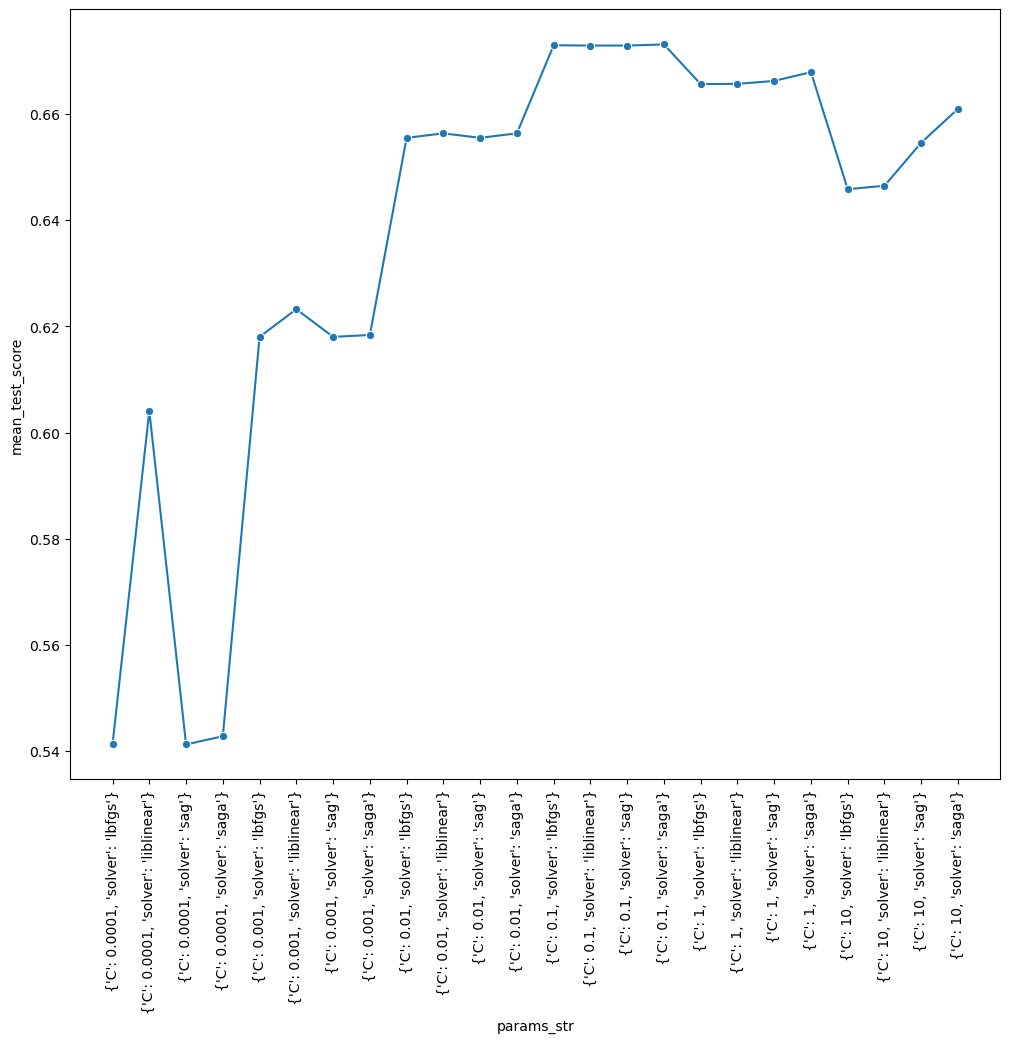

Los mejores parametros fueron: {'C': 0.1, 'solver': 'saga'}
El mejor desempeno fue: 0.6731328320802005


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      5201
           1       0.68      0.61      0.65      4849

    accuracy                           0.68     10050
   macro avg       0.68      0.67      0.67     10050
weighted avg       0.68      0.68      0.68     10050

El ROC fue de: 0.6748456332600029
---------------------------------------------------------------------


In [21]:
modelo_logistic, resultados_logistic = entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_logistic, X_train, X_test, y_train, y_test
)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


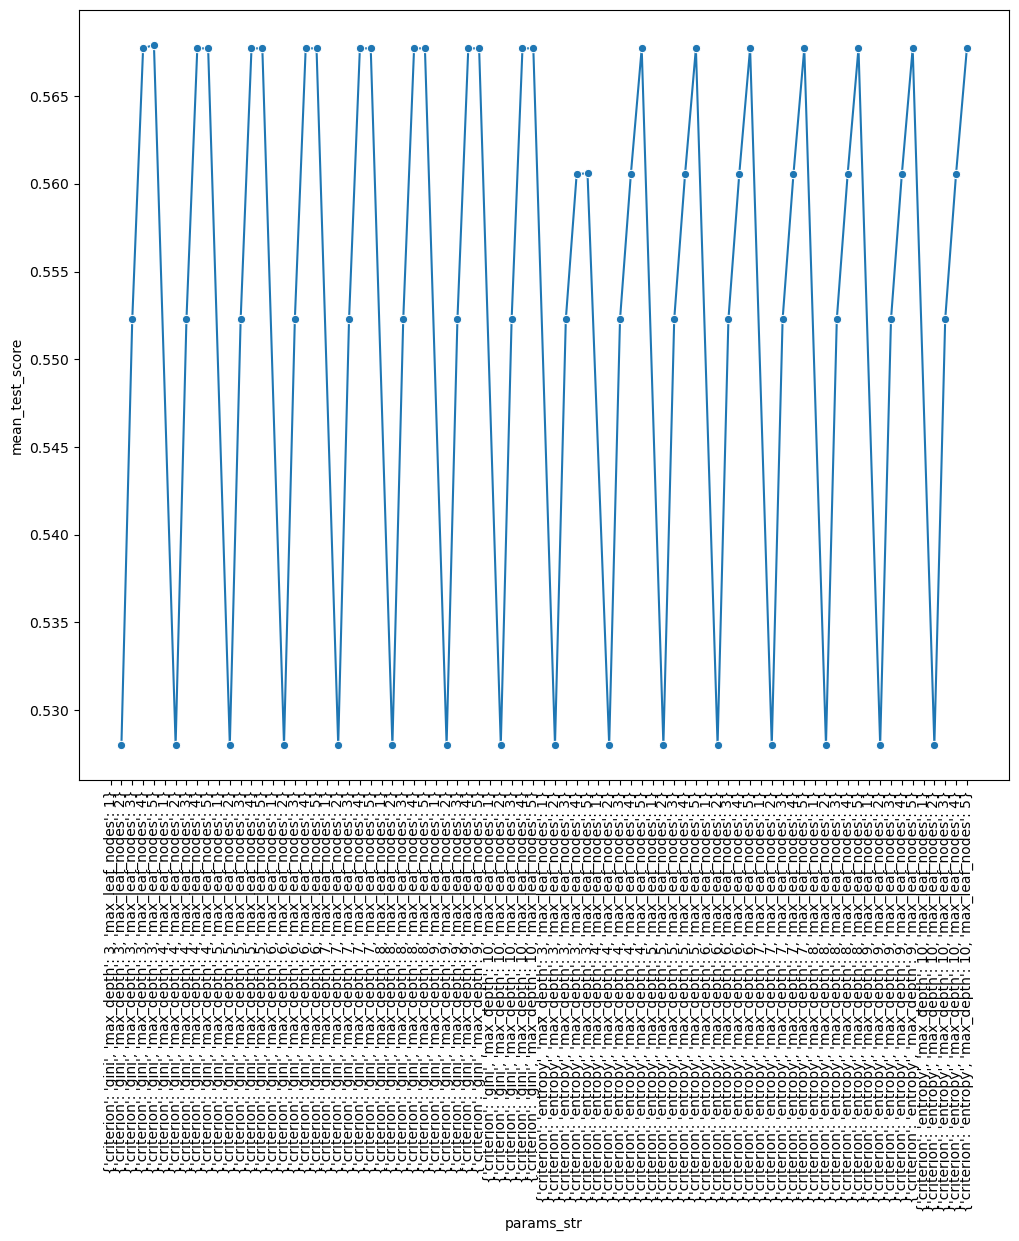

Los mejores parametros fueron: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 5}
El mejor desempeno fue: 0.5679197994987469


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      5160
           1       0.80      0.17      0.28      4890

    accuracy                           0.57     10050
   macro avg       0.67      0.56      0.49     10050
weighted avg       0.67      0.57      0.49     10050

El ROC fue de: 0.563296594854235
---------------------------------------------------------------------


In [44]:
modelo_arbol, resultados_arbol = entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_arbol, X_train, X_test, y_train, y_test
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


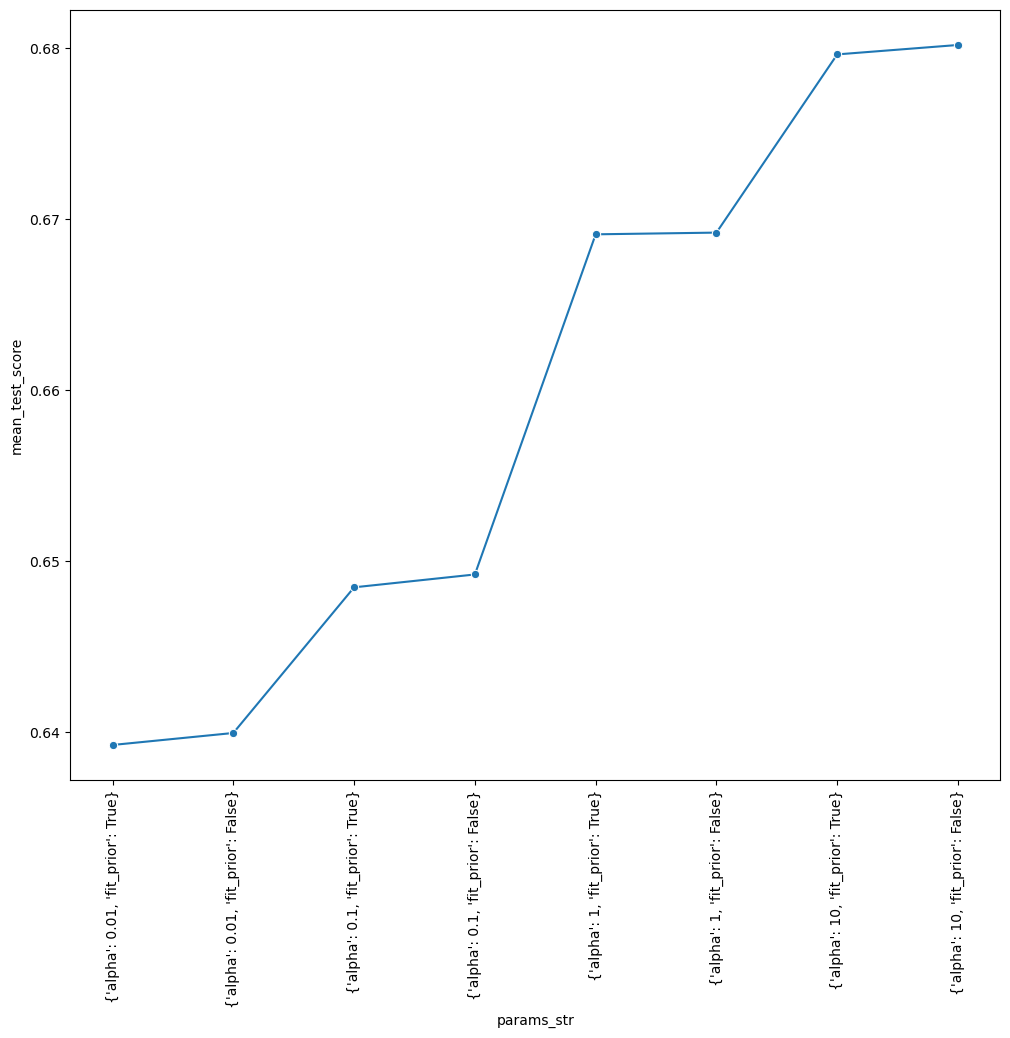

Los mejores parametros fueron: {'alpha': 10, 'fit_prior': False}
El mejor desempeno fue: 0.6802005012531327


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      5160
           1       0.66      0.68      0.67      4890

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.6737759785038282
---------------------------------------------------------------------


In [45]:
modelo_naive_bayes, resultados_naive_bayes = entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_naive_bayes, X_train, X_test, y_train, y_test
)


In [47]:
import pickle

with open(r"modelo_logistic.pickle", "wb") as file:
    pickle.dump(modelo_logistic, file)

with open(r"modelo_arbol.pickle", "wb") as file:
    pickle.dump(modelo_arbol, file)

with open(r"modelo_naive_bayes.pickle", "wb") as file:
    pickle.dump(modelo_naive_bayes, file)